# A r-fMRI preprocessing workflow

This is the rfMRI pre-processing workflow of our team: Aki, Clemens, Grace, Robin, Steve.

In [1]:
# Import Image helper to render graphs in the notebook
from IPython.display import Image
# Import workflow elements
from nipype import Node, Workflow
from nipype.interfaces import fsl, afni

In [2]:
# Import necessary interfaces and wrap them with nodes
node_bet = Node(fsl.BET(functional=True, mask=True), name='bet')
node_mcflirt = Node(fsl.MCFLIRT(save_plots=True, save_mats=True), name='mcflirt')
node_despike = Node(afni.Despike(outputtype='NIFTI_GZ'), name='despike')

In [3]:
# Initiation of a workflow
wf = Workflow(name="rfmri_preprocessing")

In [4]:
# First the "simple", but more restricted method
wf.connect(node_bet, "out_file", node_mcflirt, "in_file")
wf.connect(node_mcflirt, 'out_file', node_despike, 'in_file')

In [5]:
wf.inputs.bet.in_file='/home/jovyan/work/data/ds000114/sub-01/func/sub-01_task-fingerfootlips_bold.nii.gz'
wf.base_dir='/home/jovyan/work/outputs'

170329-21:29:58,458 workflow INFO:
	 Generated workflow graph: /home/jovyan/work/outputs/rfmri_preprocessing/graph.dot.png (graph2use=hierarchical, simple_form=True).


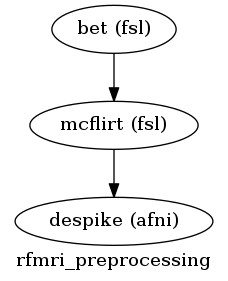

In [6]:
Image(wf.write_graph())

In [7]:
wf.run()

170329-21:29:58,535 workflow INFO:
	 Workflow rfmri_preprocessing settings: ['check', 'execution', 'logging']
170329-21:29:58,558 workflow INFO:
	 Running serially.
170329-21:29:58,563 workflow INFO:
	 Executing node bet in dir: /home/jovyan/work/outputs/rfmri_preprocessing/bet
170329-21:29:58,615 workflow INFO:
	 Running: bet /home/jovyan/work/data/ds000114/sub-01/func/sub-01_task-fingerfootlips_bold.nii.gz /home/jovyan/work/outputs/rfmri_preprocessing/bet/sub-01_task-fingerfootlips_bold_brain.nii.gz -F -m
170329-21:30:04,276 workflow INFO:
	 Executing node mcflirt in dir: /home/jovyan/work/outputs/rfmri_preprocessing/mcflirt
170329-21:30:04,312 workflow INFO:
	 Running: mcflirt -in /home/jovyan/work/outputs/rfmri_preprocessing/bet/sub-01_task-fingerfootlips_bold_brain.nii.gz -out /home/jovyan/work/outputs/rfmri_preprocessing/mcflirt/sub-01_task-fingerfootlips_bold_brain_mcf.nii.gz -mats -plots
170329-21:30:45,911 workflow INFO:
	 Executing node despike in dir: /home/jovyan/work/outpu

## Let's connect an smoothing workflow that exists in nipype
Add some nipype's utilities

In [8]:
from nipype.workflows.fmri.fsl.preprocess import create_susan_smooth
from nipype.interfaces import io as nio
from nipype.interfaces import utility as niu

Create an inputnode and a data grabber

In [9]:
node_input = Node(niu.IdentityInterface(fields=['subject_id', 'task_id']), name='inputnode')
node_dgrabber = Node(nio.DataGrabber(
    infields=['subject_id', 'task_id'],
    outfields=['func', 'anat'],
    template='*',
    base_directory='/home/jovyan/work/data/ds000114/',
    sort_filelist=True,
), name='dgrabber')

node_dgrabber.inputs.field_template = {
    'func': 'sub-%s/func/sub-%s_task-%s_bold.nii.gz',
    'anat': 'sub-%s/anat/sub-%s_T1w.nii.gz'
}
node_dgrabber.inputs.template_args = {
    'func': [['subject_id', 'subject_id', 'task_id']],
    'anat': [['subject_id', 'subject_id']]
}

Build the workflow, including the SUSAN workflow for smoothing that is shipped with nipype

In [10]:
workflow_susan = create_susan_smooth(separate_masks=False)
workflow_susan.inputs.inputnode.fwhm = 5

# Lets work only in the first 5 timepoints of the fmri dataset
node_troi = Node(fsl.ExtractROI(t_min=0, t_size=16), name='SelectROI')
# The create_susan_smooth workflow will expect the fmri to be split in a volume per timepoint
node_split = Node(fsl.Split(dimension='t'), name='split')

wf = Workflow(name="rfmri_preprocessing")
wf.base_dir='/home/jovyan/work/outputs'

# Create connections
wf.connect(node_input, 'subject_id', node_dgrabber, 'subject_id')
wf.connect(node_input, 'task_id', node_dgrabber, 'task_id')
wf.connect(node_dgrabber, 'func', node_bet, 'in_file')
wf.connect(node_bet, "out_file", node_troi, "in_file")
wf.connect(node_troi, "roi_file", node_mcflirt, "in_file")
wf.connect(node_mcflirt, 'out_file', node_despike, 'in_file')
wf.connect(node_despike, 'out_file', node_split, 'in_file')
wf.connect(node_split, 'out_files', workflow_susan, 'inputnode.in_files')
wf.connect(node_bet, 'mask_file', workflow_susan, 'inputnode.mask_file')

170329-21:30:59,250 workflow INFO:
	 Generated workflow graph: /home/jovyan/work/outputs/rfmri_preprocessing/graph.dot.png (graph2use=hierarchical, simple_form=True).


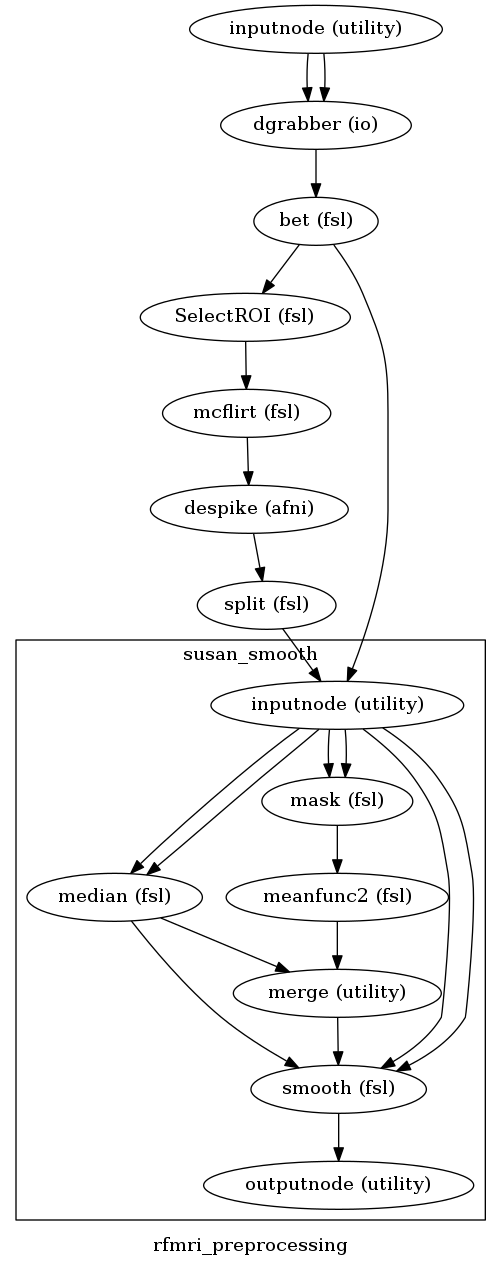

In [11]:
Image(wf.write_graph())

In [12]:
# Set the input
wf.inputs.inputnode.subject_id = '01'
wf.inputs.inputnode.task_id = 'fingerfootlips'
wf.run()

170329-21:30:59,321 workflow INFO:
	 Workflow rfmri_preprocessing settings: ['check', 'execution', 'logging']
170329-21:30:59,343 workflow INFO:
	 Running serially.
170329-21:30:59,349 workflow INFO:
	 Executing node dgrabber in dir: /home/jovyan/work/outputs/rfmri_preprocessing/dgrabber
170329-21:30:59,402 workflow INFO:
	 Executing node bet in dir: /home/jovyan/work/outputs/rfmri_preprocessing/bet
170329-21:30:59,437 workflow INFO:
	 Running: bet /home/jovyan/work/data/ds000114/sub-01/func/sub-01_task-fingerfootlips_bold.nii.gz /home/jovyan/work/outputs/rfmri_preprocessing/bet/sub-01_task-fingerfootlips_bold_brain.nii.gz -F -m
170329-21:31:05,95 workflow INFO:
	 Executing node SelectROI in dir: /home/jovyan/work/outputs/rfmri_preprocessing/SelectROI
170329-21:31:05,141 workflow INFO:
	 Running: fslroi /home/jovyan/work/outputs/rfmri_preprocessing/bet/sub-01_task-fingerfootlips_bold_brain.nii.gz /home/jovyan/work/outputs/rfmri_preprocessing/SelectROI/sub-01_task-fingerfootlips_bold_br

Let's iterate on the two subjects and the tasks:

In [18]:
# Initiation of a workflow
wf = Workflow(name="rfmri_preprocessing")

node_input = Node(niu.IdentityInterface(fields=['subject_id', 'task_id']), name='inputnode')
node_dgrabber = Node(nio.DataGrabber(
    infields=['subject_id', 'task_id'],
    outfields=['func', 'anat'],
    template='*',
    base_directory='/home/jovyan/work/data/ds000114/',
    sort_filelist=True,
), name='dgrabber')

node_dgrabber.inputs.field_template = {
    'func': 'sub-%s/func/sub-%s_task-%s_bold.nii.gz',
    'anat': 'sub-%s/anat/sub-%s_T1w.nii.gz'
}
node_dgrabber.inputs.template_args = {
    'func': [['subject_id', 'subject_id', 'task_id']],
    'anat': [['subject_id', 'subject_id']]
}

# Import necessary interfaces and wrap them with nodes
node_bet = Node(fsl.BET(functional=True, mask=True), name='bet')
node_mcflirt = Node(fsl.MCFLIRT(save_plots=True, save_mats=True), name='mcflirt')
node_despike = Node(afni.Despike(outputtype='NIFTI_GZ'), name='despike')

workflow_susan = create_susan_smooth(separate_masks=False)
workflow_susan.inputs.inputnode.fwhm = 5

# Lets work only in the first 5 timepoints of the fmri dataset
node_troi = Node(fsl.ExtractROI(t_min=0, t_size=16), name='SelectROI')
# The create_susan_smooth workflow will expect the fmri to be split in a volume per timepoint
node_split = Node(fsl.Split(dimension='t'), name='split')

# Merge back smoothing results
node_merge = Node(fsl.Merge(dimension='t'), name='merge')

node_sink = Node(nio.DataSink(base_directory='/home/jovyan/work/outputs'), name='datasink')

wf = Workflow(name="rfmri_preprocessing")
wf.base_dir='/home/jovyan/work/temp'

def _add_sub(subject_id):
    return 'sub-' + subject_id



# Create connections
wf.connect(node_input, 'subject_id', node_dgrabber, 'subject_id')
wf.connect(node_input, 'task_id', node_dgrabber, 'task_id')
wf.connect(node_dgrabber, 'func', node_bet, 'in_file')
wf.connect(node_bet, "out_file", node_troi, "in_file")
wf.connect(node_troi, "roi_file", node_mcflirt, "in_file")
wf.connect(node_mcflirt, 'out_file', node_despike, 'in_file')
wf.connect(node_despike, 'out_file', node_split, 'in_file')
wf.connect(node_split, 'out_files', workflow_susan, 'inputnode.in_files')
wf.connect(node_bet, 'mask_file', workflow_susan, 'inputnode.mask_file')
wf.connect(node_input, ('subject_id', _add_sub), node_sink, 'container')
wf.connect(workflow_susan, 'outputnode.smoothed_files', node_merge, 'in_files')
wf.connect(node_merge, 'merged_file', node_sink, 'processed')

170329-21:52:42,17 workflow INFO:
	 Generated workflow graph: /home/jovyan/work/temp/rfmri_preprocessing/graph.dot.png (graph2use=hierarchical, simple_form=True).


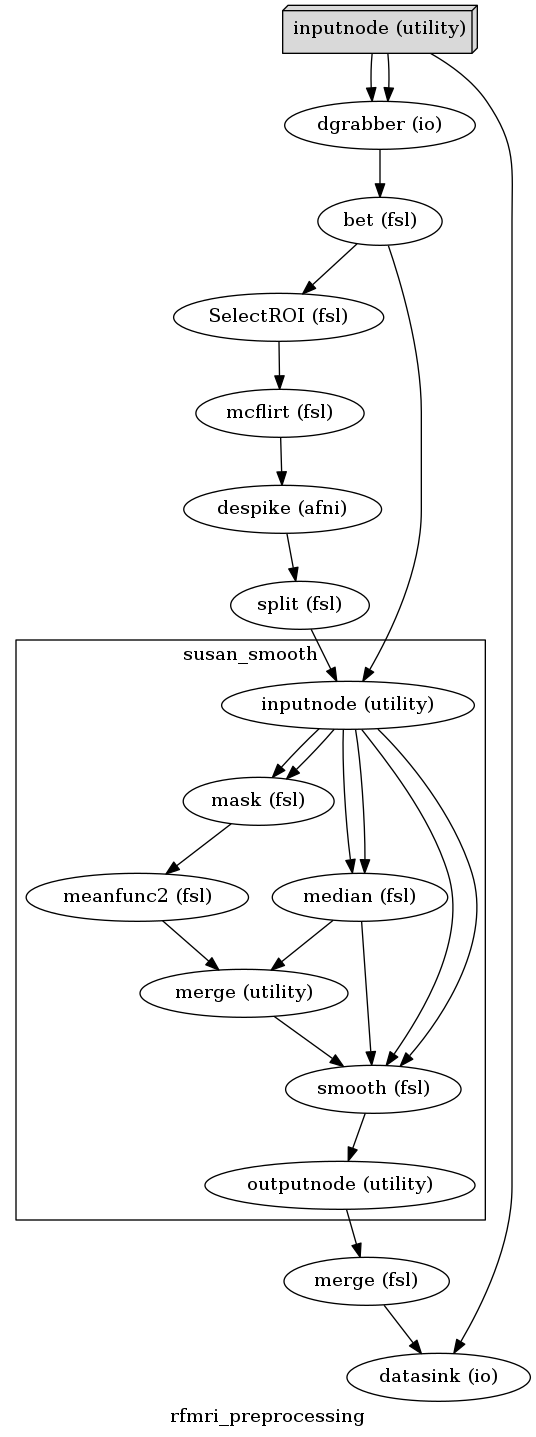

In [21]:
Image(wf.write_graph())

In [22]:
node_input.iterables = [
    ('subject_id', ['01', '02']),
    ('task_id', ['fingerfootlips', 'linebisection'])
]

In [23]:
wf.run()

170329-21:52:48,663 workflow INFO:
	 Workflow rfmri_preprocessing settings: ['check', 'execution', 'logging']
170329-21:52:48,732 workflow INFO:
	 Running serially.
170329-21:52:48,734 workflow INFO:
	 Executing node dgrabber.a1 in dir: /home/jovyan/work/temp/rfmri_preprocessing/_subject_id_01_task_id_linebisection/dgrabber
170329-21:52:48,786 workflow INFO:
	 Executing node bet.a1 in dir: /home/jovyan/work/temp/rfmri_preprocessing/_subject_id_01_task_id_linebisection/bet
170329-21:52:48,802 workflow INFO:
170329-21:52:48,809 workflow INFO:
	 Executing node SelectROI.a1 in dir: /home/jovyan/work/temp/rfmri_preprocessing/_subject_id_01_task_id_linebisection/SelectROI
170329-21:52:48,819 workflow INFO:
170329-21:52:48,824 workflow INFO:
	 Executing node dgrabber.a2 in dir: /home/jovyan/work/temp/rfmri_preprocessing/_subject_id_02_task_id_fingerfootlips/dgrabber
170329-21:52:48,892 workflow INFO:
	 Executing node bet.a2 in dir: /home/jovyan/work/temp/rfmri_preprocessing/_subject_id_02_tas